In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver


In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.adiabatic_pulse_calib
imported experiments.two_qubit.amplitude_rabi

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
expt_path=os.getcwd()+'\data'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data


# Set Config File and Results Config 

In [10]:
# Config file: 
config_file_1 = 'config_zcu216.yml'
config_path_1 = os.getcwd() + '\\' + config_file_1
print('Config will be', config_path_1)

import yaml
with open(config_file_1,'r') as cfg_file_1:
  yaml_cfg_1=AttrDict(yaml.safe_load(cfg_file_1))



Config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\config_zcu216.yml


In [17]:
# Config file: 
config_file_1 = 'config_zcu216.yml'
config_path_1 = os.getcwd() + '\\' + config_file_1
print('Config will be', config_path_1)

import yaml
with open(config_file_1,'r') as cfg_file_1:
  yaml_cfg_1=AttrDict(yaml.safe_load(cfg_file_1))





# Results config file:
results_config_file = 'test_config.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  test_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

# edit the file 
test_cfg.device.readout.trig_offset =  150

# dump it: 
test_cfg= yaml.safe_dump(test_cfg.to_dict(), default_flow_style=  True)

# write it: 
with open('test_config.yml', 'w') as modified_file:
  modified_file.write(test_cfg)

# now, open the modified file again 
with open('test_config.yml','r') as file:
  test_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

print(test_cfg.device.readout.trig_offset)


Config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\config_zcu216.yml
Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\test_config.yml
150


In [18]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
#im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [19]:
soc = QickConfig(im[yaml_cfg_1['aliases']['soc']].get_cfg())
print(soc)
print(yaml_cfg_1['aliases']['soc'])
print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 

  0%|          | 0/1000 [00:00<?, ?it/s]

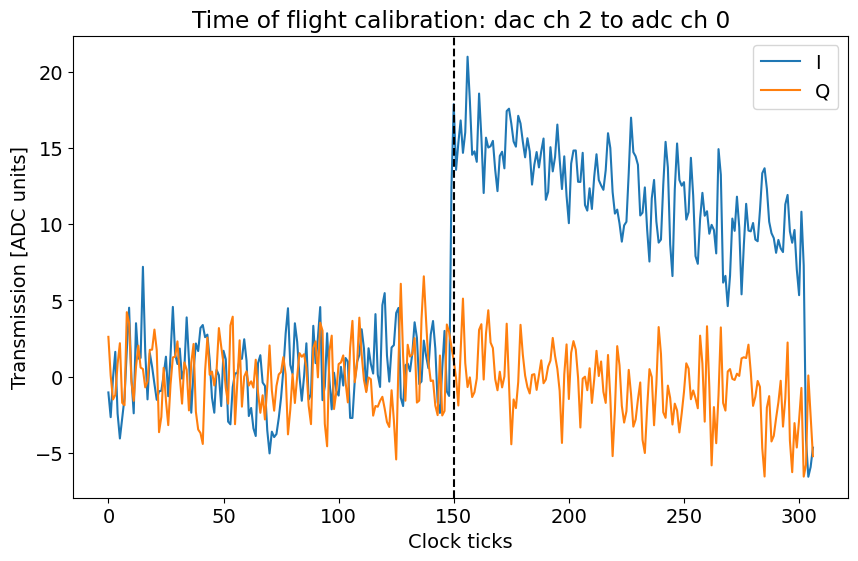

In [20]:
qubit_i = 0 
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path_1,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=30000, # blast the power just for the RFSoC calibration
    # gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try: 
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

tof.display(adc_trig_offset=150)

# Resonator Spectroscopy 

In [21]:
qubit_i = 0 

{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 

  0%|          | 0/500 [00:00<?, ?it/s]

[7097.7565, 5000, 1000, 0, 2.9879245617108174, 3.0070536783309443, 0.04809376532335885]
[ 7.09757035e+03  6.96085276e+03  1.06988935e+03 -5.43621034e-02
  1.03940329e+00  2.60310351e+00  2.71446884e-02]

Freq with minimum transmission: 7097.726500000001
Freq with maximum transmission: 7100.306500000001
From fit:
	f0: 7097.570346041007
	Qi: 6960.852761645506
	Qe: 1069.8893513958003
	Q0: 927.3541774208719
	kappa [MHz]: 7.653570252716761
	phi [radians]: -0.054362103444649645


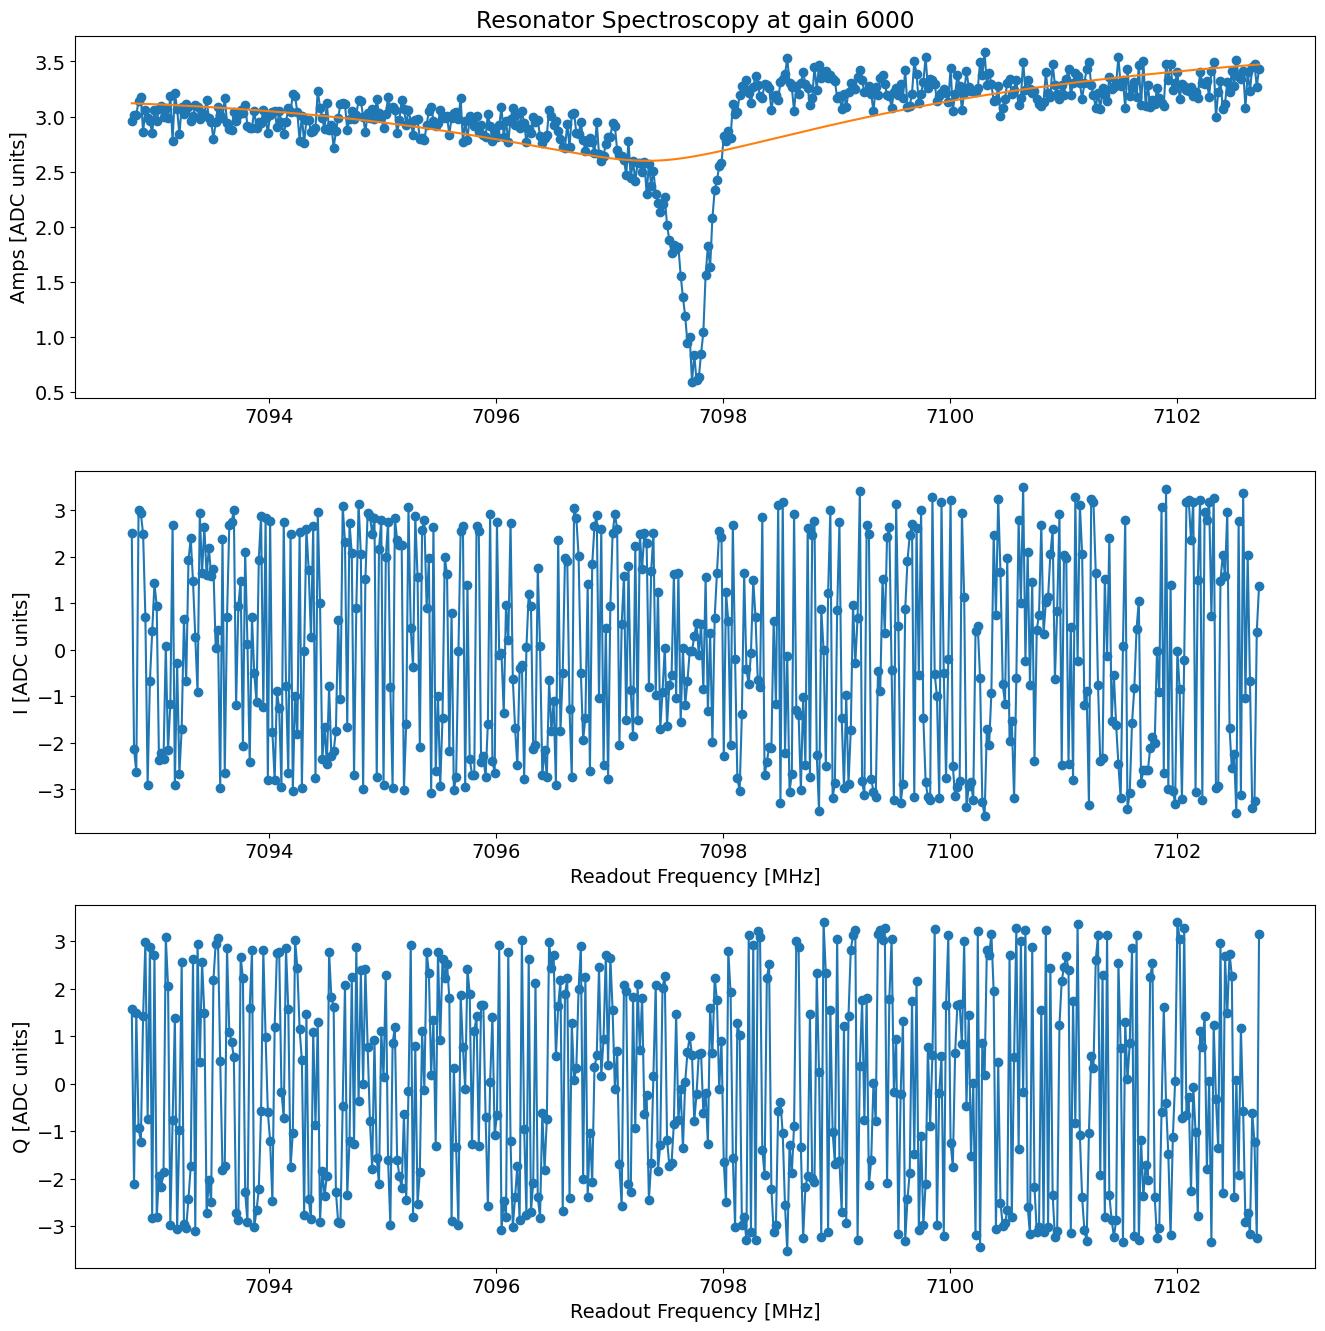

In [22]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path_1,
    # config_file=results_config_path,   
)
print(rspec.cfg)
span = 10 # MHz
npts = 500 

rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=0,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps= 500, # Number averages per point 500
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

# rspec.cfg.device.readout.gain[qubit_i] = 0.5
# rspec.cfg.device.readout.frequency[qubit_i] = 822.2138666666668

rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
# rspec.cfg.device.readout.readout_length = 5

rspec.go(analyze=False, display=False, progress=True, save=False)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=True, findpeaks=False)


In [23]:
print(test_cfg)

{'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick233'}, 'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'pulses': {'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}}}, 'readout': {'Max_amp': [0.9, 1.2, 1.0, 1.2, 1.0, 1.3], 'frequency': [7096.2465, 7130.083, 7142.48, 7199.91443566717

assign the resonator frequencies to the test_cfg file 

In [41]:
rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']

# open the results config file 
with open(results_config_file,'r') as file:
  test_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

# assign the resonator frequency to the results config file
test_cfg.device.readout.frequency[qubit_i] = float(rspec.data['xpts'][np.argmin(rspec.data['amps'])])

test_cfg= yaml.safe_dump(test_cfg.to_dict(), default_flow_style=  True)

# write it: 
with open('test_config.yml', 'w') as modified_file:
  modified_file.write(test_cfg)
# now, open the modified file again 
with open('test_config.yml','r') as file:
  test_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

print(f'*Set cfg res {qubit_i} freq to {test_cfg.device.readout.frequency[qubit_i]}*')



[7097.7565, 5000, 1000, 0, 2.9879245617108174, 3.0070536783309443, 0.04809376532335885]
[ 7.09757035e+03  6.96085276e+03  1.06988935e+03 -5.43621034e-02
  1.03940329e+00  2.60310351e+00  2.71446884e-02]

Freq with minimum transmission: 7097.726500000001
Freq with maximum transmission: 7100.306500000001
From fit:
	f0: 7097.570346041007
	Qi: 6960.852761645506
	Qe: 1069.8893513958003
	Q0: 927.3541774208719
	kappa [MHz]: 7.653570252716761
	phi [radians]: -0.054362103444649645
*Set cfg res 0 freq to 7097.726500000001*


# Power Sweep Resonator Spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [56]:
qubit_i = 0

  0%|          | 0/17 [00:00<?, ?it/s]

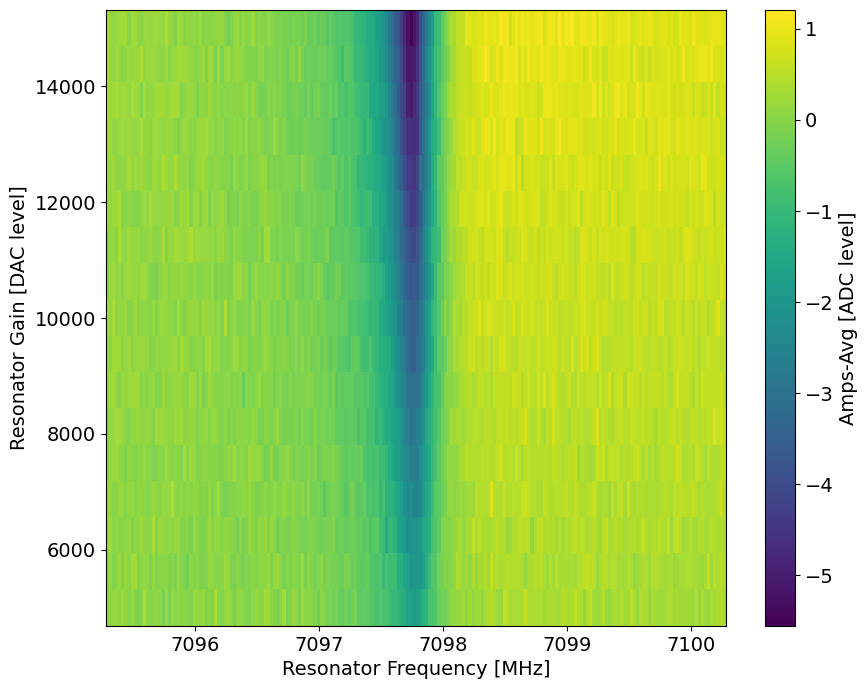

15000


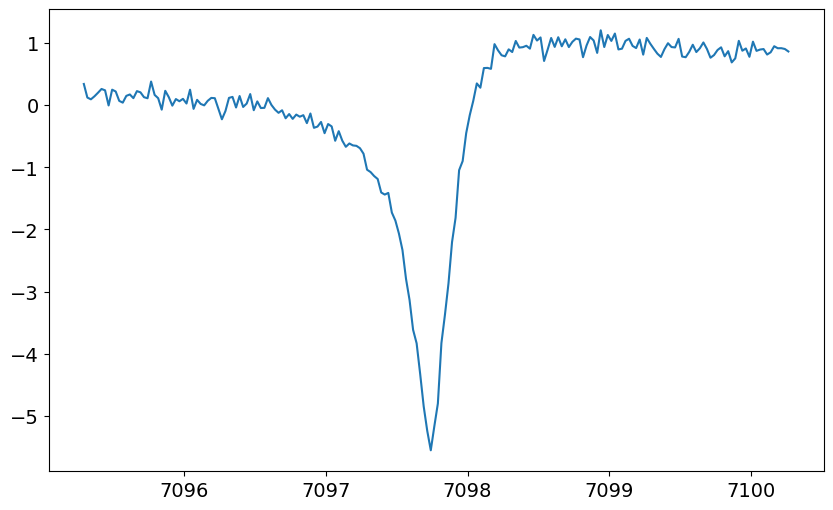

In [58]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_powersweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path_1,
)

span_f = 5.0 
npts_f =  200 

span_gain = 10000
npts_gain = 16 

rpowspec.cfg.expt = dict(
    start_f = test_cfg.device.readout.frequency[qubit_i]-span_f/2, # resonator frequency to be mixed up [MHz]
    step_f = span_f/npts_f, # min step ~1 Hz 
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=5000,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps= 500, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,  
) 

rpowspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
rpowspec.cfg.device.readout.readout_length = 5

rpowspec.go(analyze=False, display=False, progress=True, save=False)


# Testing 
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)



# Qubit |g> --> |e> Spectroscopy 

Pulse Probe (qubit) Spectroscopy 

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency. 

Qubit frequency should be stored in <code>cfg_test.device.qubit.f_ge[i]<code>

In [26]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path = expt_path, 
    prefix = f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=results_config_path,
    )

span = 20 
npts = 500

qspec.cfg.expt = dict(
    start= qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # qubit frequency to be mixed up [MHz]
    step = span/npts, # min step ~1 Hz
    expts = npts, # Number experiments stepping from start
    reps = 50, # Number averages per point
    rounds = 20, #Number of start to finish sweeps to average over 
    length = 50, # qubit probe constant pulse length [us]
    gain =100, #qubit pulse gain  
    pulse_type = 'const', #'gauss'
    qubit = qubit_i,
) 

qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)


  0%|          | 0/20 [00:00<?, ?it/s]

3305.3281430617762


Found peak in amps at [MHz] 3306.315771201113, HWHM 0.7821800599987154
Found peak in I at [MHz] 3299.825920489074, HWHM -0.0014257816488115313
Found peak in Q at [MHz] 3306.6300027342313, HWHM 10.07099619138635


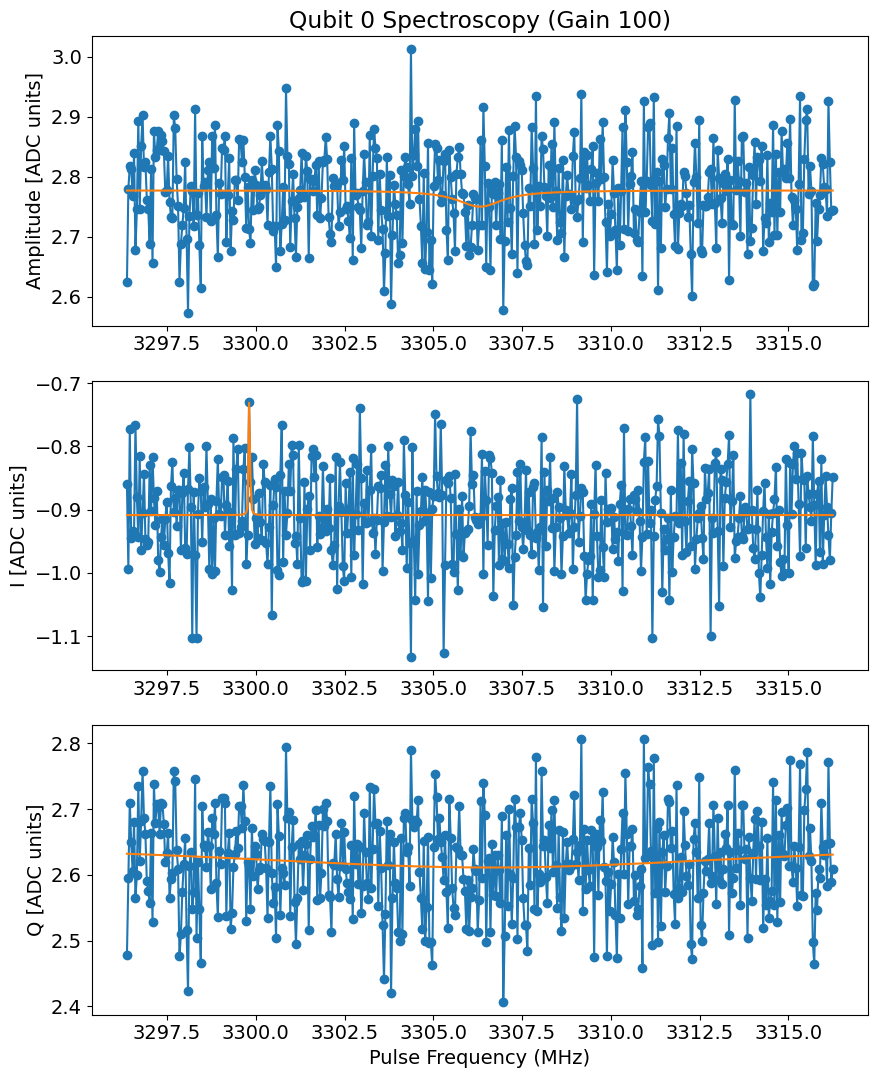

*Set cfg qubit 0 freq to 3306.315771201113*
{'device': {'qubit': {'T1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'f_ge': array([3306.3157712,    0.       ,    0.       ,    0.       ,
          0.       ,    0.       ,    0.       ,    0.       ,
          0.       ,    0.       ]), 'f_ef': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'f_EgGf': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'pulses': {'pi_ge': {'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'sigma': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'type': 'gauss'}, 'pi_ef': {'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'sigma': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'type': 'gauss'}, 'pi_EgGf': {'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'sigma': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'phase': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '

In [27]:
qspec.analyze(fit=True, signs = [1,-1,1])
qspec.display(fit=True, signs=[1, -1, 1])

#qspec_fit = qspec.data['fit']

# assign the qubit frequency to the results config file
#test_cfg.device.qubit.f_ge[qubit_i] = qspec.data['fit_amps'][np.argmax(qspec.data['fit_amps'])]

test_cfg.device.qubit.f_ge[qubit_i] = qspec.data["fit_amps"][2]

print(f'*Set cfg qubit {qubit_i} freq to {test_cfg.device.qubit.f_ge[qubit_i]}*')

print(test_cfg)

## Automation 

Everything below here will all be run in one script and all the fit data will be saved to <code>test_cfg<code>

  0%|          | 0/100 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 208.52363636363634, which is out of bounds 0.4388571428571429 to 65.82857142857142. Instead init to 33.133714285714284
Attempted to init fitparam 1 to 208.52363636363634, which is out of bounds 0.4388571428571429 to 65.82857142857142. Instead init to 33.133714285714284
Decay from avgi [us] 0.06835937500000001
Pi length from avgi data [us]: 0.0340989950484153
	Pi/2 length from avgi data [us]: 0.01704949752420765

Decay from avgq [us] 0.2285383205382871
Pi length from avgq data [us]: 0.06367650619748429
Pi/2 length from avgq data [us]: 0.03183825309874214


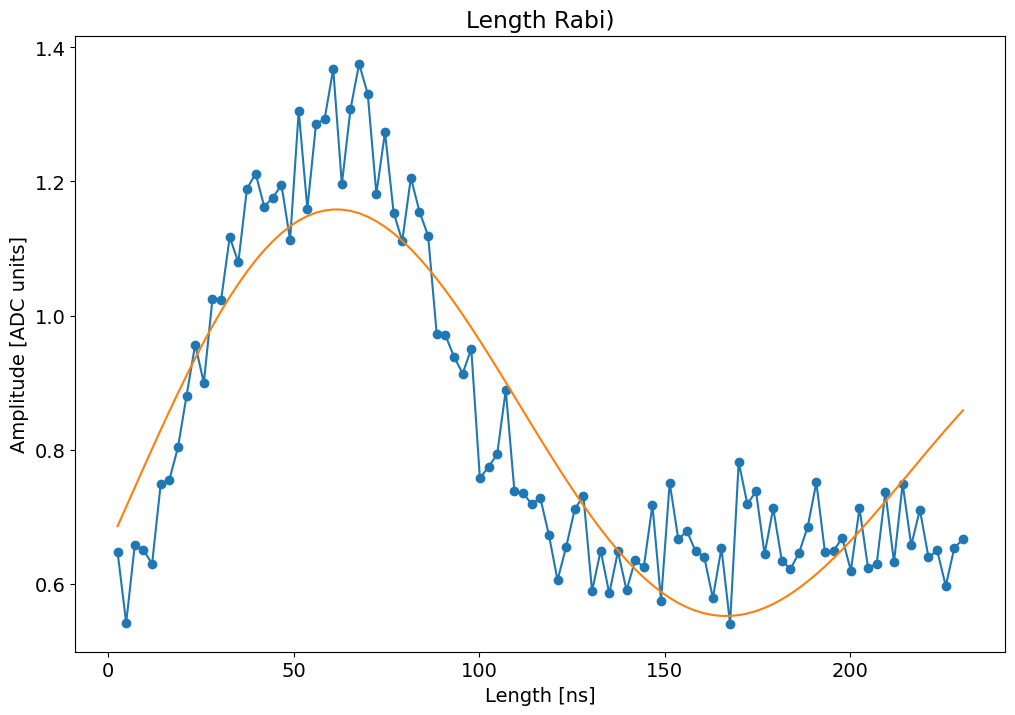

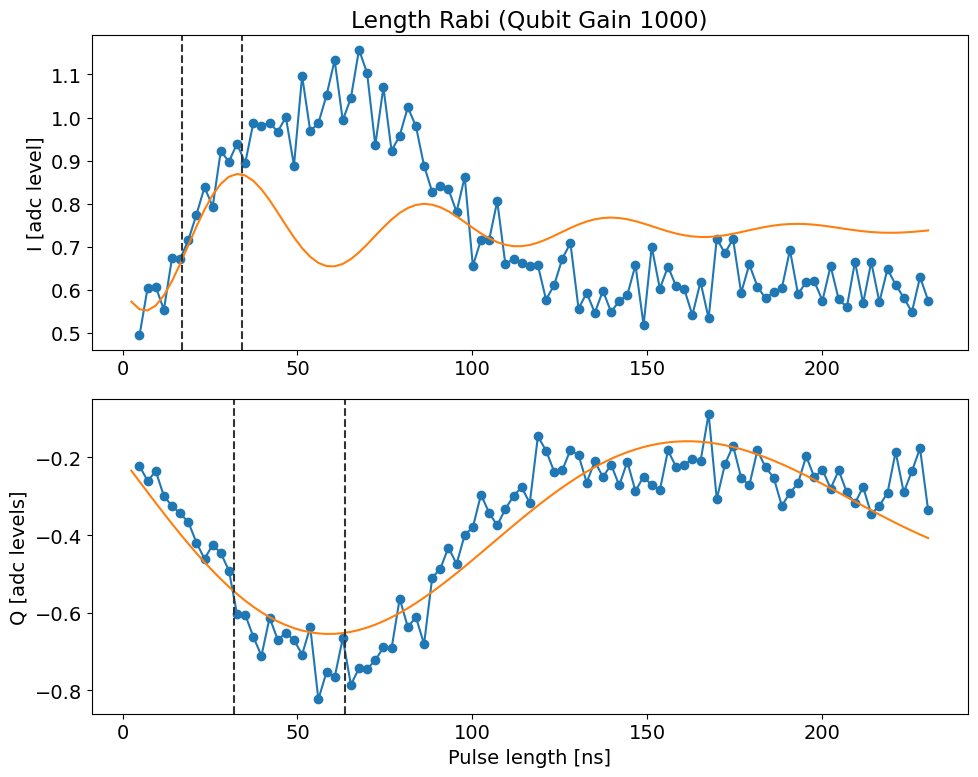

In [113]:
# Length Rabi 

lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start =  0.0025, 
    #start = 0.1915776006886583,
    #start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us] this is the samllest possible step size (size of clock cycle)
    #step = 0.01, 
    #step = 0.001, 
    expts= 100, #51 
    reps= 2000, #2000
    gain= 1000, # qubit gain [DAC units],
    #gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    # pulse_type='const',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[3,1],
)

import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

# save the pi pulse length to the results config file
p = lengthrabi.data['fit_avgi']     
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_length = (1/2 - p[2]/180)/2/p[1]
else: pi_length= (3/2 - p[2]/180)/2/p[1]

test_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = pi_length



In [115]:
# Amplitude Rabi 
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

# span = 1500
# span = 3000
span = 3000
npts = 200
amprabi.cfg.expt = dict(
    # start=0, # qubit gain [dac level]
    # start=2047,
    start=100,
    step=int(span/npts), # [dac level]
    # step=0, # [dac level]
    expts=npts,
    reps=100,
    rounds=10,
    sigma_test= test_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i], # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    pulse_type='gauss',
    # pulse_type='const',
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

#print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

amprabi.analyze(fit=True)
amprabi.display(fit=True)

p = amprabi.data['fit_amps']
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain= (3/2 - p[2]/180)/2/p[1]

test_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = pi_gain  # [DAC units]  


{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length': [5, 5, 5, 5, 

  0%|          | 0/10 [00:00<?, ?it/s]

test_config.yml
{'device': {'qubit': {'T1': [120.68761341486444, 187.33213316885298, 85.53572444033654, 179.34115523113738, 110.78317042127422, 225.12683789068893], 'f_ge': [3306.331430281384, 3559.5989142350372, 3534.728059761181, 3542.27326403314, 3270.5822861523375, 3791.61038088935], 'f_ef': [4000, 4000, 4000, 4000, 4000, 4000], 'f_EgGf': [2000, 2000, 2000, 2000, 2000, 2000], 'pulses': {'pi_ge': {'gain': [1017, 1021, 989, 969, 975, 989], 'sigma': [0.08795696668925942, 0.12184260004276688, 0.11043317188279761, 0.14281583379905646, 0.08979016287487021, 0.1977267386232169], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000, 10000, 1000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 10000, 10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': [6000, 6000, 6000, 5000, 3000, 3000], 'phase': [0, 0, 0, 0, 0, 0], 'threshold': [0, 0, 0, 0, 0, 0], 'readout_length

  0%|          | 0/10 [00:00<?, ?it/s]

Fit T1 avgi [us]: 151.55881457818128
Fit T1 avgq [us]: 137.58037200937807


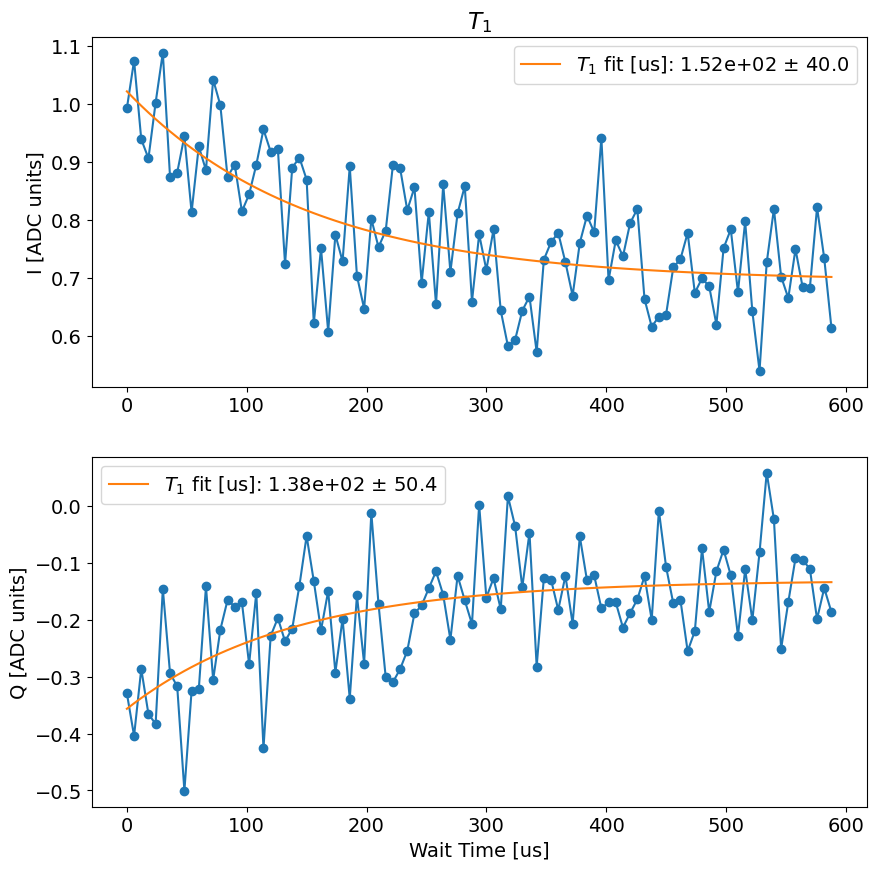

t1_i error:fit ratio= 0.2642477532602495
t1_q error:fit ratio= 0.3663235228187681
t1_i is better, saving T1_i to results cfg file


In [193]:
# T1 
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file= config_path,
)
print(config_file)

span = 600
npts = 100

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    rounds=10,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=True, display=True, progress=True, save=False)

t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])
t1_fit_i =t1.data['fit_avgi'][3]
err_ratio_i = t1_err_i/t1_fit_i
print('t1_i error:fit ratio=', err_ratio_i)

t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])
t1_fit_q =t1.data['fit_avgq'][3]
err_ratio_q = t1_err_q/t1_fit_q
print('t1_q error:fit ratio=', err_ratio_q)

if err_ratio_i< err_ratio_q:
    print('t1_i is better, saving T1_i to results cfg file') 
    test_cfg.device.qubit.T1[qubit_i] = t1_fit_i  # [DAC units]  

else: 
    print('t1_q is better, saving t1_q to results cfg file')
    test_cfg.device.qubit.T1[qubit_i] = t1_fit_q  # [DAC units]  


In [198]:
#print(test_cfg)
with open(results_config_file, 'w') as cfg_file:
    yaml.dump(test_cfg, cfg_file, default_flow_style=False)

print(test_cfg)

{'device': {'qubit': {'T1': array([151.55881458,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ]), 'f_ge': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'f_ef': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'f_EgGf': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'pulses': {'pi_ge': {'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'sigma': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'type': 'gauss'}, 'pi_ef': {'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'sigma': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'type': 'gauss'}, 'pi_EgGf': {'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'sigma': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'type': 'gauss'}}}, 'readout': {'trig_offset': 155, 'gain': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'phase': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'threshold': array([0., 0., 0., 0., 0., 0., 0